In [28]:
import requests
import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas() 

import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from sklearn.preprocessing import LabelEncoder

In [35]:
df_train = pd.read_csv("../data/train.csv")
df_test = pd.read_csv("../data/test.csv")

pre_train = pd.read_csv("../data/pre_train.csv")
pre_test = pd.read_csv("../data/pre_test.csv")

/tmp/ipykernel_621934/1715631402.py:1: DtypeWarning: Columns (16,17,36) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv("../data/train.csv")


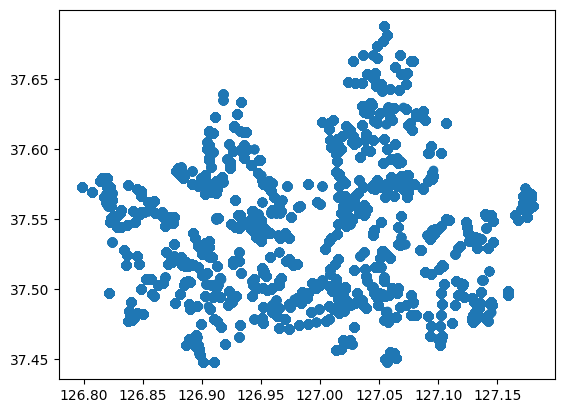

In [36]:
plt.scatter(df_train['좌표X'], df_train['좌표Y'])

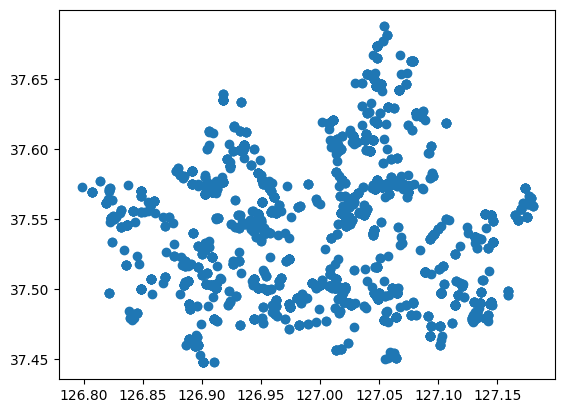

In [37]:
plt.scatter(df_test['좌표X'], df_test['좌표Y'])

In [38]:
nan_index = df_train['아파트명'].dropna(axis=0).index
df_train = df_train.iloc[nan_index]
df_train.reset_index(drop=True, inplace=True)
nan_index = df_train[df_train[['번지', '본번','부번']].isna().all(axis=1)].index
df_train.drop(nan_index, inplace=True)
df_train.reset_index(drop=True, inplace=True)
df_train[['new_x', 'new_y']] = ''
df_train[['본번', '부번']] = df_train[['본번', '부번']].astype(int)

In [39]:
df_train[['본번', '부번']] = df_train[['본번', '부번']].astype(int)
df_test[['본번', '부번']] = df_test[['본번', '부번']].astype(int)

In [41]:
api_key = '68ea765cd9f5c429a1fa932481c8c151'

In [43]:
def get_coordinates_with_fallback(region, bonbun, bubun, api_key):
    """
    주소를 단계적으로 축소해가며 좌표를 검색합니다.
    
    Parameters:
    - region (str): 행정구역 (시/도 + 구/군 + 읍/면/동)
    - bonbun (int): 본번
    - bubun (int): 부번
    - api_key (str): Kakao Maps REST API 키
    
    Returns:
    - tuple: (latitude, longitude) 또는 None (오류 시)
    """
    # 주소를 축소하는 순서대로 리스트 생성
    addresses = []
    if bubun > 0:
        addresses.append(f"{region} {bonbun}-{bubun}")  # 본번과 부번 포함
    addresses.append(f"{region} {bonbun}")  # 본번만 포함
    # addresses.append(region)  # 행정구역만 포함

    url = "https://dapi.kakao.com/v2/local/search/address.json"
    headers = {"Authorization": f"KakaoAK {api_key}"}

    for address in addresses:
        params = {"query": address}
        try:
            response = requests.get(url, headers=headers, params=params)
            response.raise_for_status()
            result = response.json()

            if result["documents"]:
                # 첫 번째 결과의 좌표 반환
                x = result["documents"][0]["x"]  # 경도
                y = result["documents"][0]["y"]  # 위도
                # print(f"주소 검색 성공: {address}")
                return float(y), float(x)
            else:
                # print(f"주소를 찾을 수 없습니다: {address}")
                pass

        except requests.exceptions.HTTPError as e:
            print(f"HTTP 오류 발생: {e}")
        except Exception as e:
            print(f"기타 오류 발생: {e}")
    
    # 모든 시도가 실패하면 None 반환
    return None

In [ ]:
unique_addresses = df_train[['시군구', '본번', '부번']].drop_duplicates()
unique_addresses

In [44]:
unique_addresses['coordinates'] = unique_addresses.progress_apply(
    lambda row: get_coordinates_with_fallback(row['시군구'], row['본번'], row['부번'], api_key=api_key), axis=1
)

100%|██████████| 8661/8661 [09:51<00:00, 14.64it/s]


In [45]:
# 원본 데이터와 병합
df_train = df_train.merge(unique_addresses, on=['시군구', '본번', '부번'], how='left')

In [54]:
df_train['new_y'] = df_train['coordinates'].astype('str').str.split(',', expand=True)[0].str.split('(', expand=True)[1].astype('float')
df_train['new_x'] = df_train['coordinates'].astype('str').str.split(',', expand=True)[1].str.split(')', expand=True)[0].astype('float')
df_train[['new_x', 'new_y']] = df_train[['new_x', 'new_y']].interpolate(method='linear')

In [55]:
unique_addresses = df_test[['시군구', '본번', '부번']].drop_duplicates()
unique_addresses

,시군구,본번,부번
0,서울특별시 강남구 개포동,658,1
1,서울특별시 강남구 개포동,651,1
2,서울특별시 강남구 개포동,652,0
5,서울특별시 강남구 개포동,187,0
6,서울특별시 강남구 개포동,185,0
...,...,...,...
9258,서울특별시 송파구 장지동,844,0
9261,서울특별시 송파구 장지동,843,0
9264,서울특별시 종로구 숭인동,2,1
9266,서울특별시 중구 묵정동,11,67


In [56]:
unique_addresses['coordinates'] = unique_addresses.progress_apply(
    lambda row: get_coordinates_with_fallback(row['시군구'], row['본번'], row['부번'], api_key=api_key), axis=1
)

100%|██████████| 2588/2588 [02:56<00:00, 14.67it/s]


In [57]:
# 원본 데이터와 병합
df_test = df_test.merge(unique_addresses, on=['시군구', '본번', '부번'], how='left')
df_test['new_y'] = df_test['coordinates'].astype('str').str.split(',', expand=True)[0].str.split('(', expand=True)[1].astype('float')
df_test['new_x'] = df_test['coordinates'].astype('str').str.split(',', expand=True)[1].str.split(')', expand=True)[0].astype('float')
df_test[['new_x', 'new_y']] = df_test[['new_x', 'new_y']].interpolate(method='linear')

In [64]:
len(pre_train), len(df_train), len(pre_test), len(df_test)

(1116621, 1116621, 9272, 9272)

In [65]:
pre_train[['좌표X', '좌표Y']] = df_train[['new_x', 'new_y']]
pre_test[['좌표X', '좌표Y']] = df_test[['new_x', 'new_y']]

In [82]:
subway = pd.read_csv("../data/subway_feature.csv")

In [83]:
# 거리 계산 (맨해튼 거리 사용)
distances = cdist(pre_train[['좌표X', '좌표Y']], subway[['경도', '위도']], metric='cityblock')

# 각 행에서 가장 가까운 인덱스와 거리 추출
closest_indices = np.argmin(distances, axis=1)
closest_distances = np.min(distances, axis=1)

# 결과를 새로운 데이터프레임에 저장
results = pd.DataFrame({
    'pre_train_index': range(len(pre_train)),
    'subway_index': closest_indices,
    'distance': closest_distances
})

In [84]:
pre_train['subway_distance'] = results['distance']
subway_selected = subway[['역사_ID','역사명', '호선']]
subway_indices = results['subway_index'].values
pre_train[['역사ID', '역사명', '호선']] = subway_selected.iloc[subway_indices].values
pre_train['역사ID'] = pre_train['역사ID'].astype('int')

In [85]:
# 거리 계산 (맨해튼 거리 사용)
distances = cdist(pre_test[['좌표X', '좌표Y']], subway[['경도', '위도']], metric='cityblock')

# 각 행에서 가장 가까운 인덱스와 거리 추출
closest_indices = np.argmin(distances, axis=1)
closest_distances = np.min(distances, axis=1)

# 결과를 새로운 데이터프레임에 저장
results = pd.DataFrame({
    'pre_train_index': range(len(pre_test)),
    'subway_index': closest_indices,
    'distance': closest_distances
})

In [86]:
pre_test['subway_distance'] = results['distance']
subway_selected = subway[['역사_ID','역사명', '호선']]
subway_indices = results['subway_index'].values
pre_test[['역사ID', '역사명', '호선']] = subway_selected.iloc[subway_indices].values
pre_test['역사ID'] = pre_test['역사ID'].astype('int')

In [89]:
# train/test 구분을 위한 칼럼을 하나 만들어 줍니다.
pre_train['is_test'] = 0
pre_test['is_test'] = 1
concat = pd.concat([pre_train, pre_test])     # 하나의 데이터로 만들어줍니다.

In [90]:
concat.reset_index(drop=True, inplace=True)

In [91]:
le = LabelEncoder()

concat['역사명'] = le.fit_transform(concat['역사명'])

In [93]:
le = LabelEncoder()

concat['호선'] = le.fit_transform(concat['호선'])

In [94]:
# 이제 다시 train과 test dataset을 분할해줍니다. 위에서 제작해 놓았던 is_test 칼럼을 이용합니다.
pre_train = concat.query('is_test==0')
pre_test = concat.query('is_test==1')

In [95]:
len(pre_train) , len(pre_test)

(1116621, 9272)

In [ ]:
# 이제 is_test 칼럼은 drop해줍니다.
pre_train.drop(['is_test'], axis = 1, inplace=True)
pre_test.drop(['is_test'], axis = 1, inplace=True)

In [99]:
# pre_train.to_csv("../data/pre_train_04.csv", index=False)
# pre_test.to_csv("../data/pre_test_04.csv", index=False)

In [46]:
bus = pd.read_csv("../data/bus_feature.csv")

pre_train = pd.read_csv("../data/pre_train_04.csv")
pre_test = pd.read_csv("../data/pre_test_04.csv")

In [47]:
batch_size = 1000  # 한 번에 처리할 데이터 크기
results = []

for start_idx in tqdm(range(0, len(pre_train), batch_size)):
    end_idx = start_idx + batch_size
    batch = pre_train[['좌표X', '좌표Y']].iloc[start_idx:end_idx].to_numpy()
    distances = np.abs(batch[:, np.newaxis, 0] - bus[['X좌표']].to_numpy().T) + \
                np.abs(batch[:, np.newaxis, 1] - bus[['Y좌표']].to_numpy().T)
    
    closest_indices = np.argmin(distances, axis=1)
    closest_distances = np.min(distances, axis=1)
    
    for idx, (closest_index, closest_distance) in enumerate(zip(closest_indices, closest_distances)):
        results.append({'pre_train_index': start_idx + idx, 'bus_index': closest_index, 'distance': closest_distance})

results_df = pd.DataFrame(results)

100%|██████████| 1117/1117 [01:12<00:00, 15.31it/s]


In [48]:
pre_train['bus_distance'] = results_df['distance']
bus_selected = bus[['노드 ID', '정류소번호', '정류소명', '정류소 타입']]
bus_indices = results_df['bus_index'].values
pre_train[['노드 ID', '정류소번호', '정류소명', '정류소 타입']] = bus_selected.iloc[bus_indices].values

In [49]:
batch_size = 1000  # 한 번에 처리할 데이터 크기
results = []

for start_idx in tqdm(range(0, len(pre_test), batch_size)):
    end_idx = start_idx + batch_size
    batch = pre_test[['좌표X', '좌표Y']].iloc[start_idx:end_idx].to_numpy()
    distances = np.abs(batch[:, np.newaxis, 0] - bus[['X좌표']].to_numpy().T) + \
                np.abs(batch[:, np.newaxis, 1] - bus[['Y좌표']].to_numpy().T)
    
    closest_indices = np.argmin(distances, axis=1)
    closest_distances = np.min(distances, axis=1)
    
    for idx, (closest_index, closest_distance) in enumerate(zip(closest_indices, closest_distances)):
        results.append({'pre_test_index': start_idx + idx, 'bus_index': closest_index, 'distance': closest_distance})

results_df = pd.DataFrame(results)

100%|██████████| 10/10 [00:00<00:00, 16.95it/s]


In [50]:
pre_test['bus_distance'] = results_df['distance']
bus_selected = bus[['노드 ID', '정류소번호', '정류소명', '정류소 타입']]
bus_indices = results_df['bus_index'].values
pre_test[['노드 ID', '정류소번호', '정류소명', '정류소 타입']] = bus_selected.iloc[bus_indices].values

In [70]:
# train/test 구분을 위한 칼럼을 하나 만들어 줍니다.
pre_train['is_test'] = 0
pre_test['is_test'] = 1
concat = pd.concat([pre_train, pre_test])     # 하나의 데이터로 만들어줍니다.

In [71]:
concat.reset_index(drop=True, inplace=True)

In [72]:
concat[['노드 ID', '정류소번호', '정류소명', '정류소 타입']].isnull().sum()

노드 ID     0
정류소번호     0
정류소명      0
정류소 타입    0
dtype: int64

In [73]:
concat[['노드 ID', '정류소번호', '정류소명', '정류소 타입']].head()

,노드 ID,정류소번호,정류소명,정류소 타입
0,122000333,23445,개포우성아파트,일반차로
1,122000333,23445,개포우성아파트,일반차로
2,122000333,23445,개포우성아파트,일반차로
3,122000333,23445,개포우성아파트,일반차로
4,122000333,23445,개포우성아파트,일반차로


In [74]:
concat[['노드 ID', '정류소번호', '정류소명', '정류소 타입']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1125893 entries, 0 to 1125892
Data columns (total 4 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   노드 ID   1125893 non-null  object
 1   정류소번호   1125893 non-null  object
 2   정류소명    1125893 non-null  object
 3   정류소 타입  1125893 non-null  object
dtypes: object(4)
memory usage: 34.4+ MB


In [75]:
concat[['노드 ID', '정류소번호']] = concat[['노드 ID', '정류소번호']].astype('int')

In [76]:
le = LabelEncoder()

concat['정류소명'] = le.fit_transform(concat['정류소명'])

In [77]:
le = LabelEncoder()

concat['정류소 타입'] = le.fit_transform(concat['정류소 타입'])

In [79]:
# 이제 다시 train과 test dataset을 분할해줍니다. 위에서 제작해 놓았던 is_test 칼럼을 이용합니다.
pre_train = concat.query('is_test==0')
pre_test = concat.query('is_test==1')

In [80]:
print(pre_train.shape, pre_test.shape)

(1116621, 98) (9272, 98)


In [81]:
pre_train.to_csv("../data/pre_train_04.csv", index=False)
pre_test.to_csv("../data/pre_test_04.csv", index=False)